# DB Puenktlichkeit
Wir starten mit ein paar imports

In [1]:
import datetime
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

module_path = os.path.abspath(os.path.join('./lib/'))
if module_path not in sys.path:
    sys.path.append(module_path)
from lib.dbahn_utils import BahnUtils

Hier den Pfad anpassen in den die paket_1_1_* zips extrahiert wurden

In [2]:
# bahn_utils = BahnUtils(Path(os.path.expanduser(f'~/Downloads/')))
bahn_utils = BahnUtils(Path("/home/ben/Schreibtisch/DB_Hackaton/streckenagent/"))

Wir lesen die Daten nun ein

In [3]:
# Read the data for november
folders = ['202010', '202011', '202012']
ret_folders = {}
for folder in folders:
    OUT = bahn_utils.read_data_folder(folder)
    ret_folders[folder] = OUT

### Plot the distribution of notifications across app installations (only top 1000)

202010
	 202010 max 13767
	 202010 mean 89.84404270549354 std 200.21953306390415
	 202010 median 33.0
202011
	 202011 max 9022
	 202011 mean 80.43662163541703 std 174.45114956193996
	 202011 median 30.0
202012
	 202012 max 11290
	 202012 mean 69.82878287672304 std 156.79144951239755
	 202012 median 24.0


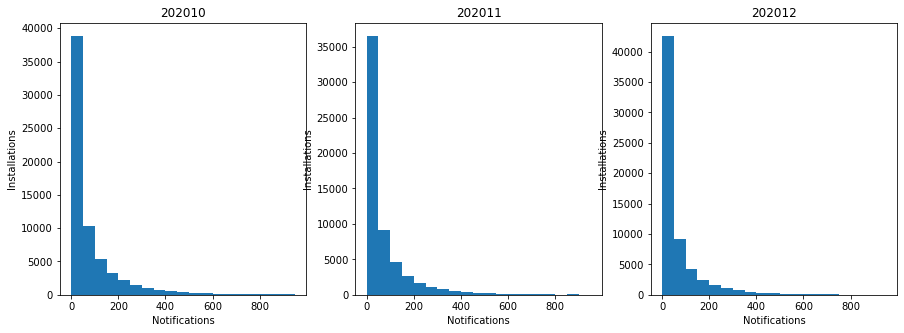

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i, (folder_name, folder_data) in enumerate(ret_folders.items()):

    push_notifications = np.asarray([v['notifications'] for k, v in folder_data[1].items()])

    print(folder_name)
    print('\t', folder_name, 'max', np.max(push_notifications))
    print('\t', folder_name, 'mean', np.nanmean(push_notifications), 'std', np.nanstd(push_notifications))
    print('\t', folder_name, 'median', np.median(push_notifications))


    axs[i].hist(push_notifications[push_notifications < 1000], np.arange(0, 1000, 50))
    axs[i].set_title(folder_name)
    # plt.scatter(x=int(np.nanmean(push_notifications[push_notifications < 1000])), y=0)

    axs[i].set_xlabel('Notifications')
    axs[i].set_ylabel('Installations')

plt.show()

### Plot the distribution of different push notification types

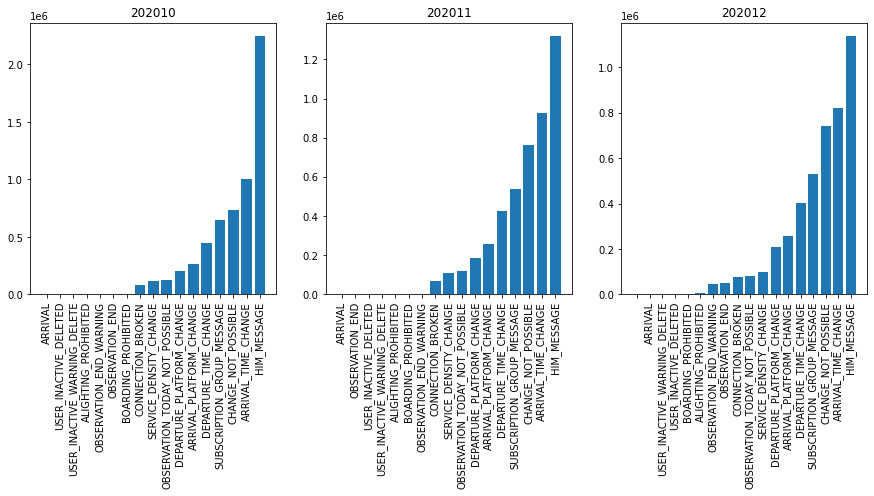

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i, (folder_name, folder_data) in enumerate(ret_folders.items()):
    key_vals = [(k, v) for k, v in folder_data[2].items()]
    key_vals = sorted(key_vals, key=lambda x: x[1])


    axs[i].bar(np.arange(0, len(key_vals)), [x[1] for x in key_vals])
    axs[i].set_xticks(np.arange(0, len(key_vals)))
    axs[i].set_xticklabels([x[0] for x in key_vals], rotation=90, rotation_mode="default")
    axs[i].set_title(folder_name)
plt.show()


### Plot the number of days the users get notifications

202010
	 202010 max 31
	 202010 mean 12.39939688390015
	 202010 median 11.0
202011
	 202011 max 30
	 202011 mean 11.859104365876068
	 202011 median 11.0
202012
	 202012 max 31
	 202012 mean 10.484940465945895
	 202012 median 9.0


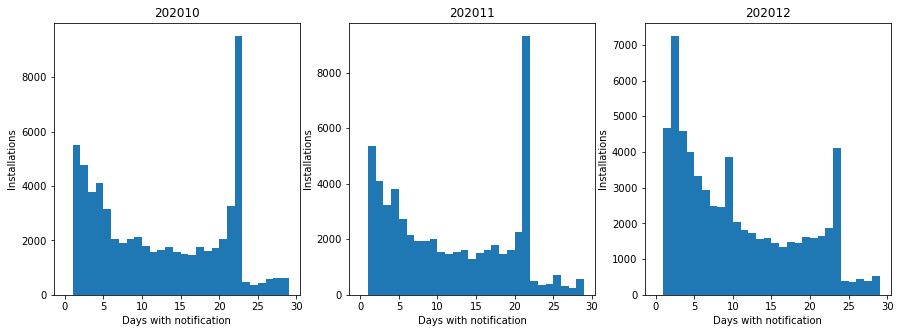

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i, (folder_name, folder_data) in enumerate(ret_folders.items()):
    push_notifications_per_day = np.asarray([len(v.keys()) - 2 for k, v in folder_data[1].items()])
    print(folder_name)
    print('\t', folder_name, 'max', np.max(push_notifications_per_day))
    print('\t', folder_name, 'mean', np.nanmean(push_notifications_per_day))
    print('\t', folder_name, 'median', np.median(push_notifications_per_day))

    axs[i].hist(push_notifications_per_day, np.arange(0, 30, 1))
    axs[i].set_xlabel('Days with notification')
    axs[i].set_ylabel('Installations')
    axs[i].set_title(folder_name)
plt.show()


### Other interesting ideas (on the overall user)
  * Notifications by weekday
  * Notifications by time of the day
    * you have to extend the read_data_folder for that
  * display for each week the area with the most notifications
    * Use the StopId / RIS api to find other close stations




In [7]:
# Filterung Pünktlichkeit als erstes nach: chanel_address: CANCELLATION, ARRIVAL_TIME_CHANGE (evtl auch DEPARTURE_TIME_CHANGE)
#
# Dann FIlterung welche Züge/Verbindungen überhaupt abonniert:
# mit TtConnectionEvent ArrivalStop->StopName & PlannedArrivalTime, Arrival Delay (für Pünktlichkeit) und DepartureStop->Stop Name und Planned Departure (evtl noch Departure Delay);

import re
import time
from collections import defaultdict


def zero():
    return 0

def plot_delay(filepath):
    i = 0
    header = None
    
    appuuid_to_notificationcount = defaultdict(zero)
    appuuid_to_totaldelay = defaultdict(zero)
    
    with open(filepath) as f:
        for line in f:
            i += 1
            if i == 1:
                header = line.split(';')
                continue

            data_split = line.split(';')
            date_str = data_split[0][:10]
            
            app_uuid_index = header.index('app_uuid')
            app_uuid = data_split[app_uuid_index]
            channel_address_index = header.index('channel_address')
            channel_address = data_split[channel_address_index]
            RtConnectionEvent_index = header.index('RtConnectionEvent')
            RtConnectionEvent = data_split[RtConnectionEvent_index]
            
            if channel_address == "ARRIVAL_TIME_CHANGE":
                appuuid_to_notificationcount[app_uuid] += 1
                # TODO parse rt-connect-event nach verspätung
                
                rt_connection_arrivaldelay = re.search('ArrivalDelay=([^,]*)', RtConnectionEvent).group(1)
                if rt_connection_arrivaldelay == "null":
                    rt_connection_arrivaldelay = 0
                rt_connection_arrivaldelay = int(rt_connection_arrivaldelay)
                #departure_station = re.search('(?<=von )(.*?)(?= (\())', RtConnectionEvent).group(1)
          #      print("DEBUG: app_uuid:", app_uuid)
          #      print("DEBUG: rt_connection_arrivaldelay:", rt_connection_arrivaldelay)
                appuuid_to_totaldelay[app_uuid] += rt_connection_arrivaldelay
          #      time.sleep(1)
    return appuuid_to_notificationcount, appuuid_to_totaldelay


                
appuuid_to_notificationcount, appuuid_to_totaldelay = plot_delay("/home/ben/Schreibtisch/DB_Hackaton/streckenagent/paket_1_1_202012_push_nachrichten/202012_push_nachrichten.csv")

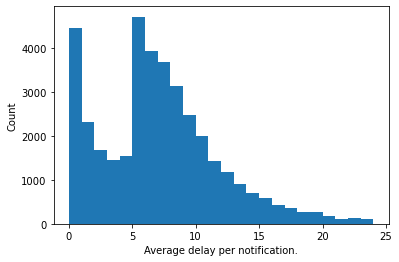

In [8]:
# print("User 106506 notificationcount:", appuuid_to_notificationcount['106506'])
# print("User 106506 totaldelay:", appuuid_to_totaldelay['106506'])
# print("Ratio:", appuuid_to_totaldelay['106506'] / appuuid_to_notificationcount['106506'])

ratio_list = []
for appuuid, notificationcount in appuuid_to_notificationcount.items():
    if appuuid_to_notificationcount[appuuid] != 0:
        ratio = appuuid_to_totaldelay[appuuid] / appuuid_to_notificationcount[appuuid]
        ratio_list.append(ratio)

plt.hist(ratio_list, bins=range(0, 25))
plt.xlabel("Average delay per notification.")
plt.ylabel("Count")
plt.show()